# Proyecto: Clasificación de Imágenes usando ResNet50V2 y Caltech-101

Este notebook tiene como objetivo clasificar imágenes del conjunto de datos Caltech-101 utilizando una red neuronal convolucional (CNN) basada en la arquitectura ResNet50V2. La arquitectura ResNet (Residual Networks) es conocida por su capacidad para entrenar redes profundas gracias a sus conexiones residuales, que ayudan a mitigar el problema del desvanecimiento del gradiente.

Este proyecto se compone de varias etapas, incluyendo la configuración de los datos, la construcción del modelo, el entrenamiento, la visualización de los resultados y la evaluación final del modelo entrenado.

## Importación de Bibliotecas y Configuración Inicial

En primer lugar, es esencial importar todas las bibliotecas necesarias para llevar a cabo las operaciones de preprocesamiento de datos, construcción del modelo y visualización. Entre las bibliotecas clave que utilizamos se encuentran `tensorflow` para construir y entrenar el modelo, y `matplotlib` para graficar los resultados.

Adicionalmente, configuramos algunos parámetros básicos, como las dimensiones de las imágenes y el tamaño de lote (batch size). Esto es importante porque afecta tanto el rendimiento como la memoria utilizada durante el entrenamiento del modelo.

In [1]:
# Importar bibliotecas necesarias
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Definir la ruta relativa donde se encuentran los datos
data_dir = 'Data/caltech-101'

# Verificar si la ruta existe
full_path = os.path.join(os.getcwd(), data_dir)
print("Ruta completa:", full_path)

if os.path.exists(full_path):
    print("La ruta existe.")
else:
    print("La ruta no existe.")

# Parámetros de preprocesamiento de imágenes
img_height, img_width = 224, 224  # Tamaño al que se redimensionarán las imágenes
batch_size = 16  # Tamaño del batch para el entrenamiento

print("Bibliotecas importadas y parámetros configurados.")


2024-08-12 09:07:14.126140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 09:07:14.137063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 09:07:14.245931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 09:07:14.332264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 09:07:14.402906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Ruta completa: /home/ronny/Documentos/RI/Proyecto_IIB/Proyecto_Modelo_Ronny/Data/caltech-101
La ruta existe.
Bibliotecas importadas y parámetros configurados.


## Generadores de Datos

El siguiente paso es preparar los datos para el entrenamiento y la validación. Usamos `ImageDataGenerator` para este propósito, una herramienta poderosa en `Keras` que permite el preprocesamiento y la aumentación de imágenes en tiempo real.

### ¿Qué es la Aumentación de Imágenes?

La aumentación de imágenes es una técnica que genera nuevas muestras de datos a partir de las imágenes existentes, aplicando transformaciones como rotación, desplazamiento, cizallamiento, zoom y volteo. Este proceso ayuda a aumentar la diversidad del conjunto de datos de entrenamiento, lo que puede llevar a un mejor rendimiento del modelo al hacer que sea más robusto frente a variaciones en las imágenes.

En este caso, configuramos dos generadores:
1. **Generador sin aumentación:** Utilizado para el conjunto de validación, ya que no deseamos introducir variaciones adicionales en las imágenes de validación.
2. **Generador con aumentación:** Utilizado para el conjunto de entrenamiento, lo que permite que el modelo vea versiones modificadas de las imágenes durante el entrenamiento, promoviendo así una mejor generalización.


In [2]:
# Generador de datos sin aumentación para validación
no_aug_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de los píxeles entre 0 y 1
    validation_split=0.2  # Reservar el 20% de los datos para validación
)

# Generador de datos con aumentación para entrenamiento
aug_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=40,  # Rotación aleatoria de las imágenes
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Cizallamiento aleatorio
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest'  # Modo de relleno
)

# Crear generadores de datos
no_aug_train_generator = no_aug_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Subconjunto de entrenamiento
)

aug_train_generator = aug_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Subconjunto de entrenamiento con aumentación
)

validation_generator = no_aug_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Subconjunto de validación
)

print("Generadores de datos configurados.")

Found 7356 images belonging to 102 classes.
Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.
Generadores de datos configurados.
Número de imágenes de entrenamiento sin aumentación: 7356
Número de imágenes de entrenamiento con aumentación: 7356
Número de imágenes de validación: 1788


Mostrando imágenes originales (sin aumentación) y sus etiquetas:


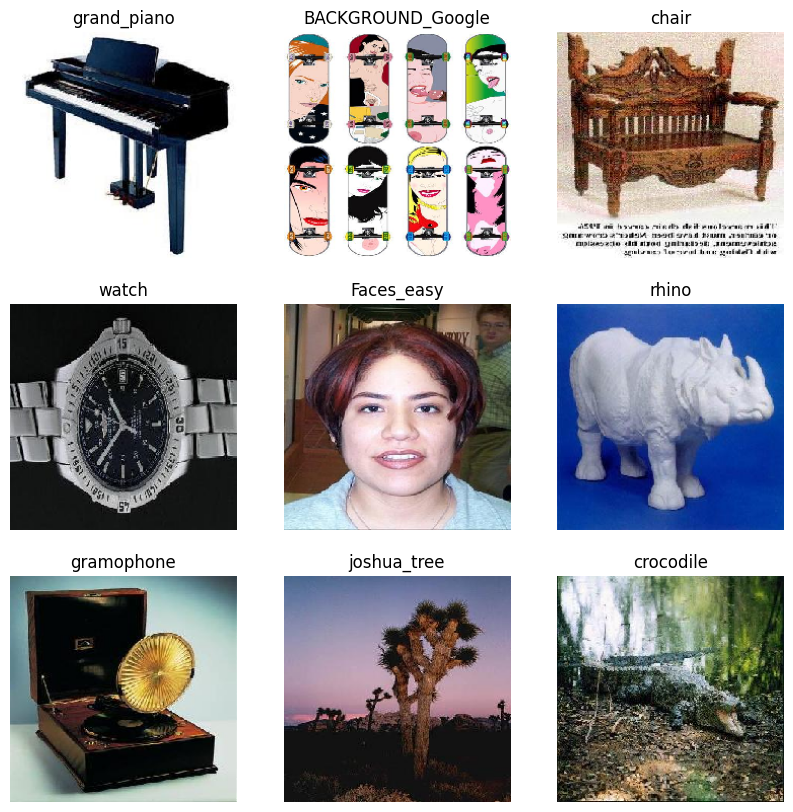

Mostrando imágenes con aumentación y sus etiquetas:


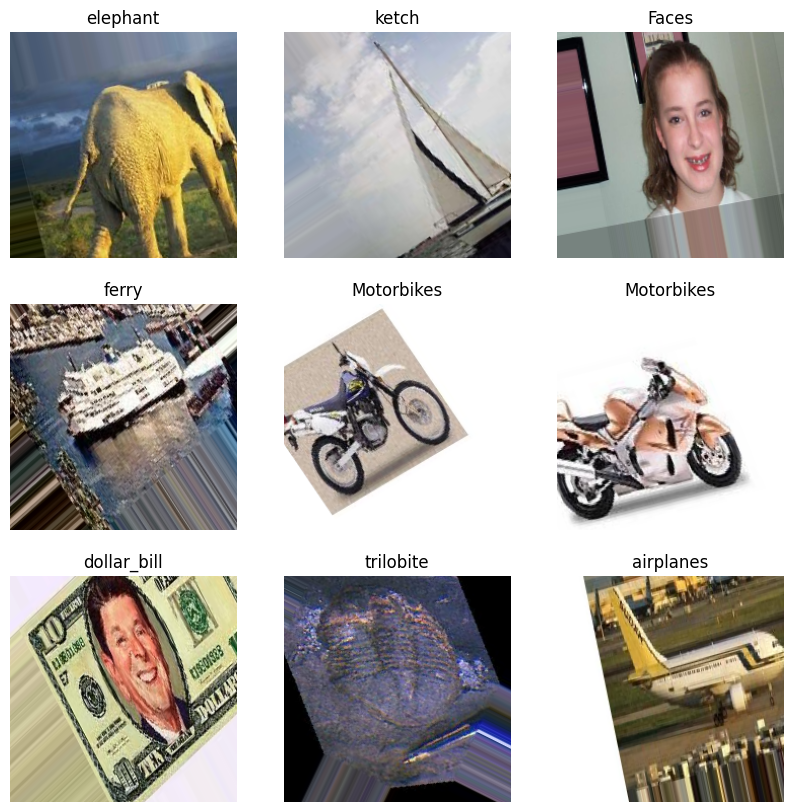

Etiquetas originales:
['grand_piano', 'BACKGROUND_Google', 'chair', 'watch', 'Faces_easy', 'rhino', 'gramophone', 'joshua_tree', 'crocodile', 'watch', 'BACKGROUND_Google', 'ketch', 'Faces', 'scorpion', 'barrel', 'pizza']
Etiquetas con aumentación:
['elephant', 'ketch', 'Faces', 'ferry', 'Motorbikes', 'Motorbikes', 'dollar_bill', 'trilobite', 'airplanes', 'airplanes', 'lobster', 'sea_horse', 'helicopter', 'flamingo', 'scorpion', 'Faces_easy']


In [3]:
# Obtener un lote de imágenes originales del generador sin aumentación
# Esto se hace usando la función 'next' para obtener el siguiente lote de imágenes y etiquetas
no_aug_images, no_aug_labels = next(no_aug_train_generator)

# Mostrar las imágenes originales (sin aumentación) junto con sus etiquetas correspondientes
print("Mostrando imágenes originales (sin aumentación) y sus etiquetas:")
plt.figure(figsize=(10, 10))  # Definir el tamaño de la figura para las imágenes
for i in range(9):  # Mostrar las primeras 9 imágenes del lote
    plt.subplot(3, 3, i + 1)  # Crear una cuadrícula de 3x3 para las imágenes
    plt.imshow(no_aug_images[i])  # Mostrar la imagen
    # Mostrar el título con la etiqueta correspondiente (nombre de la clase)
    plt.title(list(no_aug_train_generator.class_indices.keys())[np.argmax(no_aug_labels[i])])
    plt.axis('off')  # Ocultar los ejes
plt.show()  # Mostrar la figura con las imágenes

# Obtener un lote de imágenes aumentadas del generador con aumentación
aug_images, aug_labels = next(aug_train_generator)

# Mostrar las imágenes aumentadas junto con sus etiquetas correspondientes
print("Mostrando imágenes con aumentación y sus etiquetas:")
plt.figure(figsize=(10, 10))  # Definir el tamaño de la figura para las imágenes
for i in range(9):  # Mostrar las primeras 9 imágenes del lote
    plt.subplot(3, 3, i + 1)  # Crear una cuadrícula de 3x3 para las imágenes
    plt.imshow(aug_images[i])  # Mostrar la imagen
    # Mostrar el título con la etiqueta correspondiente (nombre de la clase)
    plt.title(list(aug_train_generator.class_indices.keys())[np.argmax(aug_labels[i])])
    plt.axis('off')  # Ocultar los ejes
plt.show()  # Mostrar la figura con las imágenes

# Imprimir las etiquetas de las imágenes originales
print("Etiquetas originales:")
print([list(no_aug_train_generator.class_indices.keys())[np.argmax(label)] for label in no_aug_labels])

# Imprimir las etiquetas de las imágenes aumentadas
print("Etiquetas con aumentación:")
print([list(aug_train_generator.class_indices.keys())[np.argmax(label)] for label in aug_labels])

In [4]:
# Guardar imágenes y etiquetas de entrenamiento sin aumentación
np.save('no_aug_images.npy', no_aug_images)
np.save('no_aug_labels.npy', no_aug_labels)

# Guardar imágenes y etiquetas de entrenamiento con aumentación
np.save('aug_images.npy', aug_images)
np.save('aug_labels.npy', aug_labels)

print("Imágenes y etiquetas guardadas.")

Imágenes y etiquetas guardadas.


## Construcción del Modelo

La arquitectura del modelo que utilizamos está basada en ResNet50V2, una versión mejorada de ResNet50 que incluye conexiones residuales "invertidas", diseñadas para mejorar la propagación de la información y de los gradientes en redes profundas.

### ¿Por qué usar ResNet50V2?

ResNet50V2 es una elección popular debido a su capacidad para entrenar redes extremadamente profundas sin sufrir problemas comunes como el desvanecimiento del gradiente. Esto es crucial para tareas como la clasificación de imágenes, donde un modelo profundo puede captar características complejas.

En este caso, usamos una versión preentrenada de ResNet50V2 que ha sido entrenada en el conjunto de datos ImageNet. Al congelar las capas del modelo preentrenado, aseguramos que el modelo mantenga el conocimiento adquirido durante su entrenamiento en ImageNet. A continuación, añadimos capas personalizadas para adaptar el modelo a la tarea específica de clasificación de las categorías del conjunto de datos Caltech-101.


In [5]:
# Importar las clases y funciones necesarias para construir el modelo

# ResNet50V2 es una arquitectura de red neuronal profunda que ha sido preentrenada en el conjunto de datos ImageNet,
# un gran conjunto de datos que contiene millones de imágenes clasificadas en miles de categorías.
from tensorflow.keras.applications import ResNet50V2

# Model es una clase que nos permite crear un modelo Keras a partir de las capas que especificamos.
# GlobalAveragePooling2D es una capa que reduce la dimensionalidad de las características, calculando el promedio global.
# Dense es una capa completamente conectada utilizada en las etapas finales de la red para la clasificación.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Cargar el modelo ResNet50V2 preentrenado
# 'weights' se establece en 'imagenet', lo que indica que estamos cargando un modelo preentrenado en el conjunto de datos ImageNet.
# 'include_top=False' significa que no estamos cargando la capa superior del modelo, la cual normalmente está configurada para clasificar
# 1000 clases del conjunto de datos ImageNet. Esto nos permite añadir nuestras propias capas de clasificación personalizadas.
# 'input_shape' define la forma de la entrada, que debe coincidir con las dimensiones de las imágenes que estamos utilizando en este proyecto.
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congelar las capas del modelo base
# Aquí, iteramos a través de cada capa del modelo base y establecemos su atributo 'trainable' en False.
# Esto significa que los pesos de estas capas no se actualizarán durante el entrenamiento, manteniendo el conocimiento que
# el modelo ha adquirido previamente al ser entrenado en ImageNet. Esta técnica es útil para aprovechar características preentrenadas
# mientras entrenamos las nuevas capas personalizadas que hemos añadido.
for layer in base_model.layers:
    layer.trainable = False

# Confirmar que el modelo ha sido cargado y las capas han sido congeladas
print("Modelo ResNet50 cargado y capas congeladas.")


Modelo ResNet50 cargado y capas congeladas.


In [6]:
# Añadir capas personalizadas

# Utilizar la salida del modelo base (ResNet50V2) como entrada para las nuevas capas
x = base_model.output

# Añadir una capa de GlobalAveragePooling2D
# Esta capa reduce la dimensionalidad de las características extraídas por la ResNet50V2,
# calculando el promedio de los valores en cada canal. Esto reduce significativamente
# el número de parámetros y ayuda a prevenir el sobreajuste.
x = GlobalAveragePooling2D()(x)

# Añadir una capa densa (completamente conectada) con 1024 neuronas y función de activación ReLU
# Esta capa introduce una no linealidad que permite al modelo aprender combinaciones complejas
# de características extraídas. La activación ReLU (Rectified Linear Unit) es comúnmente utilizada
# porque introduce no linealidad y es computacionalmente eficiente.
x = Dense(1024, activation='relu')(x)

# Añadir la capa de salida con una neurona por cada clase en el conjunto de datos
# La función de activación 'softmax' convierte las salidas en probabilidades, permitiendo que el
# modelo realice una clasificación multiclase. El número de neuronas es igual al número de clases
# presentes en el conjunto de datos (determinado por 'no_aug_train_generator.class_indices').
predictions = Dense(len(no_aug_train_generator.class_indices), activation='softmax')(x)

# Crear el modelo final
# Se define el modelo especificando las entradas del modelo base y las salidas personalizadas que acabamos de añadir.
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
# Se compila el modelo para prepararlo para el entrenamiento.
# 'Adam' es un optimizador adaptativo que ajusta la tasa de aprendizaje para cada parámetro.
# 'categorical_crossentropy' es la función de pérdida utilizada para problemas de clasificación multiclase.
# 'accuracy' es la métrica utilizada para evaluar el rendimiento del modelo durante el entrenamiento y la validación.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Imprimir confirmación de que las capas personalizadas se han añadido y el modelo se ha compilado
print("Capas personalizadas añadidas y modelo compilado.")

Capas personalizadas añadidas y modelo compilado.


## Entrenamiento del Modelo

El entrenamiento del modelo es el proceso en el cual la red aprende a mapear entradas (imágenes) a salidas (categorías de imágenes) ajustando sus pesos en función de los errores cometidos en las predicciones. Durante el entrenamiento, monitorizamos dos métricas clave: la pérdida y la precisión, tanto en el conjunto de entrenamiento como en el de validación.

### Pérdida y Precisión

- **Pérdida:** Es una medida del error del modelo en su predicción. Durante el entrenamiento, el objetivo es minimizar esta pérdida.
- **Precisión:** Representa el porcentaje de predicciones correctas. Es una métrica directa del rendimiento del modelo.

Aquí entrenamos el modelo durante 50 épocas, lo que significa que el modelo verá el conjunto de entrenamiento 50 veces. Este número puede ajustarse dependiendo del rendimiento observado.


In [7]:
# Entrenar el modelo

# Definir el número de épocas para el entrenamiento
# Una época se define como una iteración completa sobre el conjunto de datos de entrenamiento.
# Aquí se establece en 25, lo que significa que el modelo verá todo el conjunto de datos de entrenamiento 50 veces.
# Puedes ajustar este valor según las necesidades específicas del proyecto o basándote en la observación de las métricas de rendimiento.
epochs = 25  # Puedes ajustar el número de épocas según tus necesidades

# Entrenar el modelo utilizando el generador de datos con aumentación
# El método 'fit' entrena el modelo para un número fijo de iteraciones (épocas).
history = model.fit(
    aug_train_generator,  # Generador de datos de entrenamiento con aumentación
    epochs=epochs,  # Número de épocas definidas
    validation_data=validation_generator,  # Generador de datos de validación
    steps_per_epoch=aug_train_generator.samples // batch_size,  # Número de pasos de entrenamiento por época
    # El número de pasos por época se calcula dividiendo el número total de imágenes de entrenamiento
    # entre el tamaño del lote (batch size). Esto determina cuántos lotes se necesitan para cubrir todo el conjunto de datos.
    validation_steps=validation_generator.samples // batch_size  # Número de pasos de validación por época
    # Similar a steps_per_epoch, pero para el conjunto de validación.
)

# Imprimir una confirmación cuando el entrenamiento haya finalizado
print("Entrenamiento completado.")


Epoch 1/50


/home/ronny/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 419ms/step - accuracy: 0.6345 - loss: 1.7040 - val_accuracy: 0.8654 - val_loss: 0.4775
Epoch 2/50
  1/459 ━━━━━━━━━━━━━━━━━━━━ 2:21 309ms/step - accuracy: 0.7500 - loss: 1.2774

2024-08-12 09:11:12.024269: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.7500 - loss: 1.2774 - val_accuracy: 0.8333 - val_loss: 0.3511
Epoch 3/50


2024-08-12 09:11:12.279485: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 187s 406ms/step - accuracy: 0.8524 - loss: 0.4932 - val_accuracy: 0.8773 - val_loss: 0.4673
Epoch 4/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - accuracy: 0.8750 - loss: 0.6590 - val_accuracy: 0.9167 - val_loss: 0.3825
Epoch 5/50


2024-08-12 09:14:19.699280: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 187s 407ms/step - accuracy: 0.8881 - loss: 0.3716 - val_accuracy: 0.8801 - val_loss: 0.4456
Epoch 6/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.8750 - loss: 0.6713 - val_accuracy: 0.9167 - val_loss: 0.6451
Epoch 7/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 423ms/step - accuracy: 0.9052 - loss: 0.3130 - val_accuracy: 0.8823 - val_loss: 0.4438
Epoch 8/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.8750 - loss: 0.7303 - val_accuracy: 0.7500 - val_loss: 0.9162
Epoch 9/50


2024-08-12 09:20:42.730988: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 191s 415ms/step - accuracy: 0.9017 - loss: 0.3144 - val_accuracy: 0.8953 - val_loss: 0.3988
Epoch 10/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.9375 - loss: 0.1028 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 11/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 193s 419ms/step - accuracy: 0.9162 - loss: 0.2721 - val_accuracy: 0.8739 - val_loss: 0.4723
Epoch 12/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.8333 - val_loss: 1.1460
Epoch 13/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 191s 414ms/step - accuracy: 0.9227 - loss: 0.2553 - val_accuracy: 0.8795 - val_loss: 0.4985
Epoch 14/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8750 - loss: 0.1911 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 15/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 192s 418ms/step - accuracy: 0.9309 - loss: 0.2380 - val_accuracy: 0.8908 - val_loss: 0.4593
Epoch 16/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 1.0000 - loss: 0.023

2024-08-12 09:33:31.544004: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 425ms/step - accuracy: 0.9373 - loss: 0.2102 - val_accuracy: 0.8789 - val_loss: 0.5444
Epoch 18/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.8125 - loss: 0.4244 - val_accuracy: 0.7500 - val_loss: 0.7090
Epoch 19/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 198s 431ms/step - accuracy: 0.9413 - loss: 0.1864 - val_accuracy: 0.8902 - val_loss: 0.5379
Epoch 20/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 1.0000 - val_loss: 1.3538e-04
Epoch 21/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 191s 414ms/step - accuracy: 0.9420 - loss: 0.2026 - val_accuracy: 0.8536 - val_loss: 0.7929
Epoch 22/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 23/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 190s 412ms/step - accuracy: 0.9544 - loss: 0.1542 - val_accuracy: 0.8750 - val_loss: 0.5654
Epoch 24/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.8750 - loss: 0

2024-08-12 09:59:13.755137: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 423ms/step - accuracy: 0.9490 - loss: 0.1839 - val_accuracy: 0.8806 - val_loss: 0.6161
Epoch 34/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.9375 - loss: 0.3053 - val_accuracy: 0.8333 - val_loss: 0.6466
Epoch 35/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 193s 418ms/step - accuracy: 0.9523 - loss: 0.1821 - val_accuracy: 0.8896 - val_loss: 0.6068
Epoch 36/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.9375 - loss: 0.0511 - val_accuracy: 0.8333 - val_loss: 2.6883
Epoch 37/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 192s 417ms/step - accuracy: 0.9529 - loss: 0.1671 - val_accuracy: 0.8840 - val_loss: 0.6276
Epoch 38/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.8333 - val_loss: 1.1033
Epoch 39/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 424ms/step - accuracy: 0.9625 - loss: 0.1347 - val_accuracy: 0.9037 - val_loss: 0.5500
Epoch 40/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.8750 - loss: 0.176

## Visualización de Resultados

Después del entrenamiento, es crucial analizar el rendimiento del modelo visualizando las curvas de pérdida y precisión. Esto nos permite detectar si el modelo está aprendiendo correctamente, si se está sobreajustando, o si hay algún problema en el proceso de entrenamiento.

- **Sobreajuste (Overfitting):** Ocurre cuando el modelo se ajusta demasiado bien a los datos de entrenamiento y no generaliza bien a los datos de validación. Se observa cuando la precisión de entrenamiento sigue mejorando mientras que la precisión de validación se estabiliza o empeora.
- **Subajuste (Underfitting):** Ocurre cuando el modelo no se ajusta bien ni a los datos de entrenamiento ni a los de validación, lo que indica que el modelo es demasiado simple para capturar la complejidad de los datos.


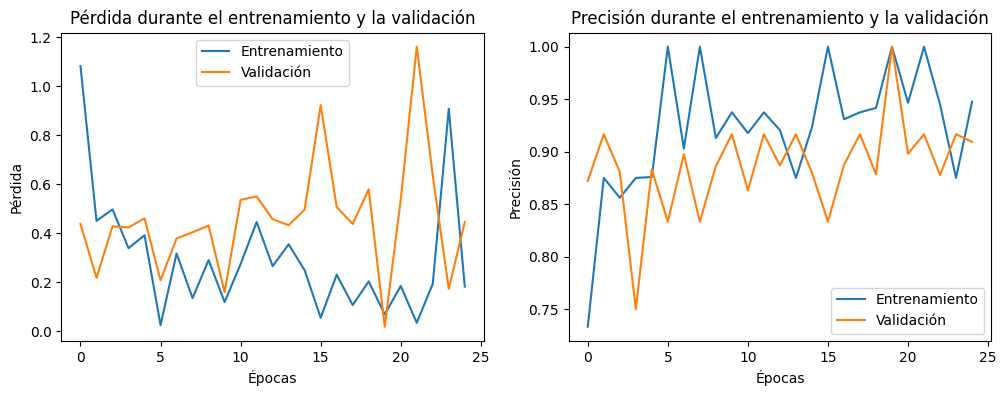

In [16]:
# Importar la biblioteca de visualización
import matplotlib.pyplot as plt

# Crear una figura con un tamaño de 12x4 pulgadas
plt.figure(figsize=(12, 4))

# Crear el primer gráfico para la pérdida
plt.subplot(1, 2, 1)  # Dividir la figura en una rejilla de 1 fila y 2 columnas, y seleccionar la primera celda
plt.plot(history.history['loss'], label='Entrenamiento')  # Graficar la pérdida de entrenamiento
plt.plot(history.history['val_loss'], label='Validación')  # Graficar la pérdida de validación
plt.title('Pérdida durante el entrenamiento y la validación')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje x
plt.ylabel('Pérdida')  # Etiqueta del eje y
plt.legend()  # Mostrar la leyenda del gráfico

# Crear el segundo gráfico para la precisión
plt.subplot(1, 2, 2)  # Seleccionar la segunda celda en la rejilla de 1 fila y 2 columnas
plt.plot(history.history['accuracy'], label='Entrenamiento')  # Graficar la precisión de entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación')  # Graficar la precisión de validación
plt.title('Precisión durante el entrenamiento y la validación')  # Título del gráfico
plt.xlabel('Épocas')  # Etiqueta del eje x
plt.ylabel('Precisión')  # Etiqueta del eje y
plt.legend()  # Mostrar la leyenda del gráfico

# Mostrar los gráficos creados
plt.show()

## Evaluación y Guardado del Modelo

Finalmente, evaluamos el modelo en el conjunto de validación para obtener métricas cuantitativas sobre su rendimiento. Las métricas obtenidas, como la pérdida y la precisión en validación, nos indican cómo de bien generaliza el modelo a datos que no ha visto durante el entrenamiento.

Una vez satisfechos con el rendimiento del modelo, lo guardamos para su uso posterior. Este modelo guardado puede cargarse en el futuro para hacer predicciones en nuevas imágenes o para seguir entrenando si se disponen de más datos.


In [17]:
# Evaluar el modelo

# Evaluar el modelo en el conjunto de datos de validación
# El método 'evaluate' permite calcular la pérdida (loss) y otras métricas del modelo sobre un conjunto de datos específico.
# En este caso, se evalúa en el conjunto de validación para obtener una medida de qué tan bien está generalizando el modelo
# a datos que no ha visto durante el entrenamiento.
val_loss, val_accuracy = model.evaluate(
    validation_generator,  # Generador de datos de validación
    steps=validation_generator.samples // batch_size  # Número de pasos necesarios para evaluar todo el conjunto de validación
    # Al igual que en el entrenamiento, el número de pasos se calcula dividiendo el número total de imágenes de validación
    # entre el tamaño del lote (batch size).
)

# Imprimir los resultados de la evaluación
# Se imprimen la pérdida (val_loss) y la precisión (val_accuracy) obtenidas en el conjunto de validación.
# La pérdida es una medida del error cometido por el modelo, mientras que la precisión indica el porcentaje de predicciones correctas.
print(f"Loss en validación: {val_loss}")
print(f"Precisión en validación: {val_accuracy}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 331ms/step - accuracy: 0.9121 - loss: 0.4101
Loss en validación: 0.4455278515815735
Precisión en validación: 0.9093468189239502


In [2]:
# Guardar el modelo entrenado

# Guardar el modelo en un archivo .h5
# El método 'save' guarda todo el modelo en un archivo, incluyendo:
# - La arquitectura del modelo, lo que permite reconstruir el modelo exactamente igual.
# - Los pesos del modelo, que son los valores ajustados durante el entrenamiento.
# - La configuración de entrenamiento (optimizer, loss, metrics).
# - El estado del optimizador, lo que permite retomar el entrenamiento exactamente donde se dejó.
# En este caso, el modelo se guarda en un archivo llamado 'resnet50v2_caltech101.h5'.
model.save('resnet50v2_caltech101.h5')

# Confirmar que el modelo ha sido guardado correctamente
print("Modelo guardado.")


NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


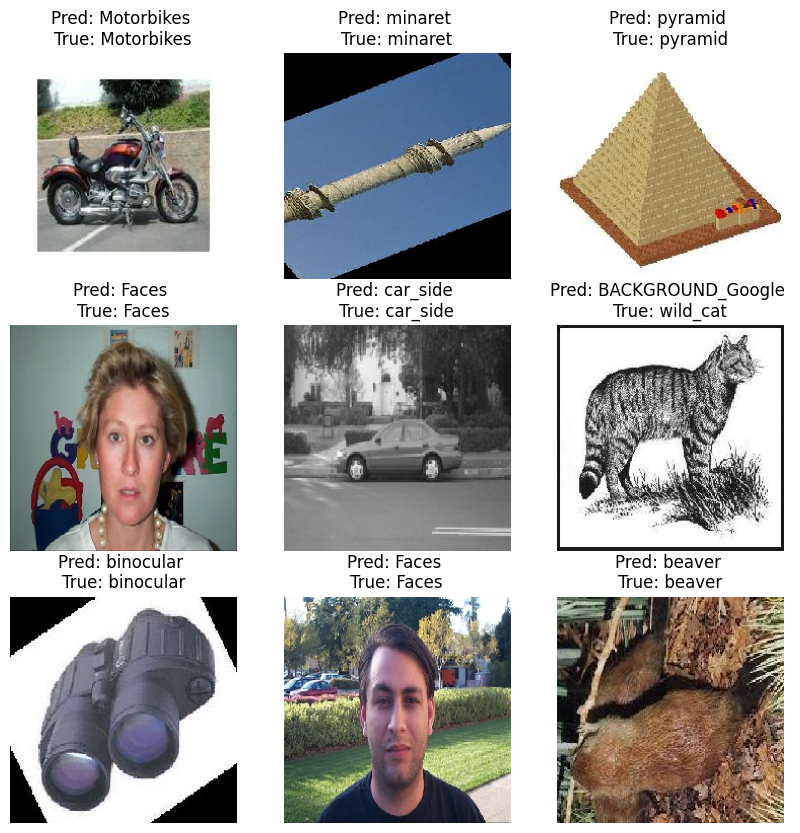

In [39]:
# Hacer predicciones sobre el lote de imágenes seleccionadas

# Utilizar el modelo entrenado para hacer predicciones sobre las imágenes de prueba
# El método 'predict' genera predicciones de salida para las entradas proporcionadas.
# En este caso, 'test_images' es el conjunto de imágenes sobre las cuales queremos realizar predicciones.
# El resultado, 'predictions', es un array donde cada fila corresponde a las probabilidades predichas
# para cada clase en la imagen respectiva.
predictions = model.predict(test_images)

# Mostrar las imágenes con las etiquetas predichas y las etiquetas verdaderas
plt.figure(figsize=(10, 10))  # Configurar el tamaño de la figura para visualizar las imágenes
for i in range(9):  # Mostrar las primeras 9 imágenes del conjunto de prueba
    plt.subplot(3, 3, i + 1)  # Crear una cuadrícula de 3x3 para las imágenes
    plt.imshow(test_images[i])  # Mostrar la imagen

    # Obtener la clase predicha (con el valor máximo) y la clase verdadera
    pred_class = np.argmax(predictions[i])  # Índice de la clase con mayor probabilidad en la predicción
    true_class = np.argmax(test_labels[i])  # Índice de la clase verdadera en las etiquetas de prueba

    # Configurar el título de la imagen con la clase predicha y la clase verdadera
    # 'Pred' indica la clase predicha por el modelo, y 'True' indica la clase real de la imagen.
    plt.title(f"Pred: {list(no_aug_train_generator.class_indices.keys())[pred_class]} \nTrue: {list(no_aug_train_generator.class_indices.keys())[true_class]}")
    plt.axis('off')  # Ocultar los ejes para una visualización más clara
plt.show()  # Mostrar la figura con las imágenes y las etiquetas

In [42]:
# Obtener las clases presentes en el lote de prueba
present_classes = np.unique(true_classes)

# Generar el reporte de clasificación solo para las clases presentes
print("Reporte de clasificación:")
print(classification_report(true_classes, pred_classes, labels=present_classes, target_names=[list(no_aug_train_generator.class_indices.keys())[i] for i in present_classes]))

# Mostrar la matriz de confusión para las clases presentes
print("Matriz de confusión:")
print(confusion_matrix(true_classes, pred_classes, labels=present_classes))


Reporte de clasificación:
              precision    recall  f1-score   support

       Faces       1.00      1.00      1.00         2
    Leopards       1.00      1.00      1.00         1
  Motorbikes       1.00      1.00      1.00         3
      beaver       1.00      1.00      1.00         1
   binocular       1.00      1.00      1.00         1
    car_side       1.00      1.00      1.00         1
         cup       1.00      1.00      1.00         1
       ferry       1.00      1.00      1.00         1
     minaret       1.00      1.00      1.00         1
     pyramid       1.00      1.00      1.00         1
   sea_horse       1.00      1.00      1.00         1
       watch       1.00      1.00      1.00         1
    wild_cat       0.00      0.00      0.00         1

   micro avg       1.00      0.94      0.97        16
   macro avg       0.92      0.92      0.92        16
weighted avg       0.94      0.94      0.94        16

Matriz de confusión:
[[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

/home/ronny/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ronny/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ronny/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
